# Pulsed optical excitation simulation

This notebook estimates the impact of our finite duration optical excitation. There is a finite chance that the NV will decay back to its ground state during this excitation process, which leads to an infidelity since this can result in double excitation of the NV during one attempt at spin-photon entanglement generation.

This notebook neglects all dynamics apart from optical excitation and spontaneous emission. More detailed simulations are given in []

### Method

We use a simple quantum-jump simulation type approach to estimate the impact of this affect. The quantum dynamics are calculated using unitary evolution and the [qutip package](http://qutip.org/). We use a Monte-Carlo approach to get the distribution of the dynamics.


In [10]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import qutip

In [17]:
# Some initial qutip definitions

ket0 = qutip.basis(2,0)
ket1 = qutip.basis(2,1)

# Pauli matrices
identity = qutip.qeye(2)
sx = qutip.sigmax()/2
sy = qutip.sigmay()/2
sz = qutip.sigmaz()/2
    
def spin_y_rotation(theta):
	return (-1j*sy*theta).expm()

### Constants and parameters

In [42]:
time_duration = 50 # Duration of simulation
pulse_center = 5 # Centre of pulse in time
dt = 0.05 # dt for sim
FWHMs = np.array([0.5,2.26,4]) # The full-width half maximum of the pulse
mus = FWHMs/2.35482004503 # Convert to standard deviation

repetitions = 1000 # How many times to repeat for Monte-Carlo

init_state = ket0.full() # Set the initial state (before optical pulse)
zero_state = ket0.full() # State that excited state decays to 

scaled_rabi_rotation = 1.0 # How much of a full pi pulse to implement

NV_lifetime = 12.0
decay_prob_per_step = dt/NV_lifetime

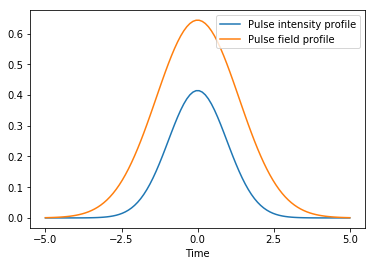

In [43]:
ts  = np.linspace(0,10,100)
plt.plot(ts-5,norm.pdf(ts, pulse_center, 2.26/2.35), label ='Pulse intensity profile')
plt.plot(ts-5,np.sqrt(norm.pdf(ts, pulse_center, 2.26/2.35)), label = 'Pulse field profile')
plt.xticks([-5,-2.5,0,2.5,5])
plt.xlabel('Time')
plt.legend()
plt.show()

### Simulation

In [44]:
total_points = np.ceil(time_duration/np.float(dt) + 1).astype(int)
points = np.arange(total_points).astype(int)
t_array = dt * points
excited_pops = np.zeros([np.shape(mus)[0],total_points])
emitted_photons = np.zeros([np.shape(mus)[0],total_points])
double_pulse_probs = np.zeros(np.shape(mus)[0])
p_photon_during_pulse = np.zeros(np.shape(mus)[0])
p_photon_after_pulse = np.zeros(np.shape(mus)[0])

for kk,mu in enumerate(mus):
    pulse_cut = pulse_center + 3*mu # Point at which we say the pulse ends, and after which we keep all detected photons
    pulse_cut_ind = np.argmin(np.abs(t_array - pulse_cut))

    pulse_EField_shape = np.sqrt(norm.pdf(t_array, pulse_center, mu))
    # Need to correct power to ensure full rabi
    EFieldFactor = 2*np.arcsin(np.sqrt(scaled_rabi_rotation))/(2**(0.75) * (np.pi)**(0.25) * np.sqrt(mu))
    instaneous_rabi_freq = pulse_EField_shape*EFieldFactor
    unitary = np.zeros([total_points,2,2],dtype=complex)
    for ii in points:
        unitary[ii] = spin_y_rotation(instaneous_rabi_freq[ii] * dt).full()

    excited_pop = np.zeros([repetitions,total_points])
    emitted_photon = np.zeros([repetitions,total_points])
    for jj in range(repetitions):
        decay_chance_for_step = np.random.rand(total_points)
        bright_state_chance_for_step = np.random.rand(total_points)
        state = init_state
        for ii in points:
            state =  np.dot(unitary[ii], state)
            excited_pop[jj,ii] = np.abs(state[1])**2
            if decay_chance_for_step[ii] < decay_prob_per_step:
                state = zero_state
                if bright_state_chance_for_step[ii] < excited_pop[jj,ii]:
                    emitted_photon[jj,ii] = 1

    excited_pops[kk] = np.mean(excited_pop,axis=0)
    emitted_photons[kk] = np.mean(emitted_photon,axis=0)
    photon_during_pulse = np.sum(emitted_photon[:,0:pulse_cut_ind],axis=1).astype(int)
    photon_after_pulse = np.sum(emitted_photon[:,pulse_cut_ind:],axis=1).astype(int)
    
    p_photon_during_pulse[kk] = np.mean(photon_during_pulse)
    p_photon_after_pulse[kk] = np.mean(photon_after_pulse)
    double_pulse_probs[kk] = np.mean(np.logical_and(photon_during_pulse,photon_after_pulse))

cond_prob_double_pulse = double_pulse_probs/p_photon_after_pulse


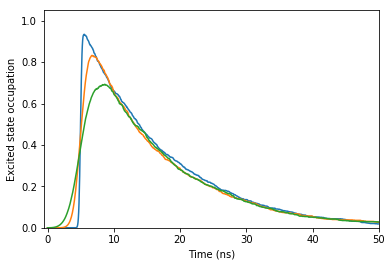

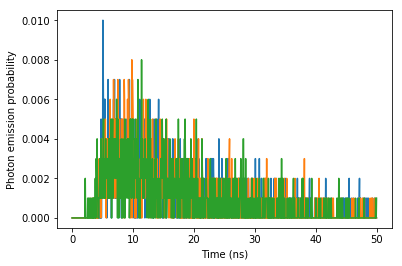

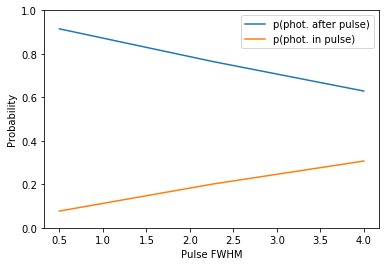

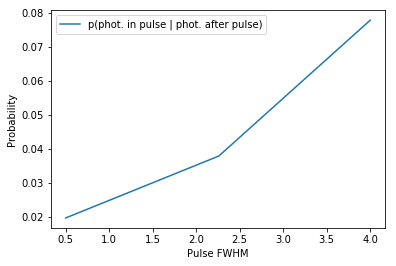

In [45]:
plt.figure()
plt.plot(t_array,np.transpose(excited_pops))
plt.ylim([0,1.05]);
plt.xlim([-0.5,50])
plt.xlabel('Time (ns)')
plt.ylabel('Excited state occupation')

plt.figure()
plt.plot(t_array,np.transpose(emitted_photons))
plt.xlabel('Time (ns)')
plt.ylabel('Photon emission probability')

plt.figure()
plt.plot(FWHMs,p_photon_after_pulse,label = 'p(phot. after pulse)')
plt.plot(FWHMs,p_photon_during_pulse,label = 'p(phot. in pulse)')
plt.xlabel('Pulse FWHM')
plt.ylabel('Probability')
plt.ylim([0,1]);
plt.legend()

plt.figure()
plt.plot(FWHMs,cond_prob_double_pulse,label = 'p(phot. in pulse | phot. after pulse)')
plt.xlabel('Pulse FWHM')
plt.ylabel('Probability')
plt.legend();

And here is the key metric, the probability of double excitation given that detected a photon after the pulse:

In [46]:
print cond_prob_double_pulse

[ 0.01967213  0.0379085   0.07790143]
